#### The data comprises tweets pertaining to common causes of cancer. The objective is to classify the tweets as medically relevant or not.  The dataset is skewed with positive class or 'yes' being 6 times less frequent than the negative class. 

In [1]:
# these are the modules you are allowed to work with. 
import nltk
import re
import numpy as np
import mxnet as mx
import sys, os
import random

'''
First job is to clean and preprocess the social media text. (5)

1) Replace URLs and mentions (i.e strings which are preceeded with @)
2) Segment #hastags 
3) Remove emoticons and other unicode characters
'''

def preprocess_tweet(input_text):
    '''
    Input: The input string read directly from the file
    
    Output: Pre-processed tweet text
    '''
    s= re.sub(r"(?:\@|https?\://)\S+", "", input_text) #removing hashtags and mentions
    s=re.sub(r'[^\x00-\x7f]',r'', s)  #removing emoticons and unicode characters
    r=[]
    for i in s.split(): #segmenting hashtags
        if i.startswith("#"):
            i=i[1:]
            splitted = re.sub('(?!^)([A-Z][a-z]+)', r' \1', i).split()
            r.extend(splitted)
        else:
            r.append(i)
    cleaned_text = ' '.join(r) 
    cleaned_text = re.sub(r'[^\w\s]','',cleaned_text) # removing punctuation such as . , ? ! which unnecessarily increase vocab size
    cleaned_text=cleaned_text.lower() # converting words to lower case
    
    return cleaned_text


# read the input file and create the set of positive examples and negative examples. 

file=open('cancer_data.tsv')
pos_data=[]
neg_data=[]

for line in file:
    line=line.strip().split('\t')
    text2= preprocess_tweet(line[0]).strip().split()
    if line[1]=='yes':
        pos_data.append(text2)
    if line[1]=='no':
        neg_data.append(text2)

print(len(pos_data), len(neg_data))     

sentences= list(pos_data)
sentences.extend(neg_data)
#print (sentences)
pos_labels= [1 for _ in pos_data]
neg_labels= [0 for _ in neg_data]
y=list(pos_labels)
y.extend(neg_labels)
y=np.array(y)

'''
After this you will obtain the following :

1) sentences =  List of sentences having the positive and negative examples with all the positive examples first
2) y = List of labels with the positive labels first.
'''

'''
Before running the CNN there are a few things one needs to take care of: (5)

1) Pad the sentences so that all of them are of the same length
2) Build a vocabulary comprising all unique words that occur in the corpus
3) Convert each sentence into a corresponding vector by replacing each word in the sentence with the index in the vocabulary. 

Example :
S1 = a b a c
S2 = d c a 

Step 1:  S1= a b a c, 
         S2 =d c a </s> 
         (Both sentences are of equal length). 

Step 2:  voc={a:1, b:2, c:3, d:4, </s>: 5}

Step 3:  S1= [1,2,1,3]
         S2= [4,3,1,5]

'''
def pad_sentences(sentences, padding_word=""): #function for padding sentences
    """
    Pads all sentences to be the length of the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
        
    return padded_sentences


def build_vocab(sentences): #function for building vocabulary
    

    """
    Builds a vocabulary mapping from token to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    d={}
    i=0
    for sentence in sentences:
        for word in sentence:
            if word not in d:
                d[word]=i
                i=i+1
    return d,i

    
            
def create_word_vectors(sentences):  #function for creating the word vectors
    '''
    Input: List of sentences
    Output: List of word vectors corresponding to each sentence, vocabulary
    '''
    sentences_padded = pad_sentences(sentences)
    #print (len(sentences_padded[3]))
    vocabulary,vocab_size = build_vocab(sentences_padded)
    word_vectors= np.array([
            [vocabulary[word] for word in sentence]
            for sentence in sentences_padded])
    
    
    
    return word_vectors, vocabulary, vocab_size


x, vocabulary, vocab_size = create_word_vectors(sentences)
sentence_size=len(x[0])
print (vocab_size)
print (sentence_size)



def create_shuffle(x,y):
    '''
    Create an equal distribution of the positive and negative examples. 
    Please do not change this particular shuffling method.
    '''
    pos_len= len(pos_data)
    neg_len= len(neg_data)
    pos_len_train= int(0.8*pos_len)
    neg_len_train= int(0.8*neg_len)
    train_data= [(x[i],y[i]) for i in range(0, pos_len_train)]
    train_data.extend([(x[i],y[i]) for i in range(pos_len, pos_len+ neg_len_train )])
    test_data=[(x[i],y[i]) for i in range(pos_len_train, pos_len)]
    test_data.extend([(x[i],y[i]) for i in range(pos_len+ neg_len_train, len(x) )])
    
    random.shuffle(train_data)
    x_train=[i[0] for i in train_data]
    y_train=[i[1] for i in train_data]
    random.shuffle(test_data)
    x_test=[i[0] for i in test_data]
    y_test=[i[1] for i in test_data]
    
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test= np.array(x_test)
    y_test= np.array(y_test)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test= create_shuffle(x,y)




(208, 1298)
7724
117


In [2]:
'''
We now define the neural architecture of the CNN. The architecture is defined as : (10)

1) Embedding layer that converts the vector representation of the sentence from a one-hot encoding to a fixed sized word embedding
   (mx.sym.Embedding)
   
2) Convolution + activation + max pooling layer 
   (mx.sym.Convolution+ mx.sym.Activation+ mx.sym.Pooling)
   This procedure is to be followed for different sizes of filters (the filters corresponding to size 2 looks at the bigram distribution, 3 looks at trigram etc. 

3) Concat all the filters together (mx.sym.Concat)

4) Pass the results through a fully Connected layer of size 2 and then run softmax on it. 
   (mx.sym.FullyConnected, mx.sym.SoftmaxOutput)
   

We then initialize the intermediate layers of appropriate size and train the model using back prop. (10)
(Look up the mxnet tutorial if you have any doubt)

Run the classifier and for each epoch with a specified batch size observe the accuracy on the training set and test set (5)


Default parameters:

1) No of epochs = 10
2) Batch size = 20
3) Size of word embeddings = 200
4) Size of filters =[2,3,4,5]
5) Filter embedding= 100
6) Optimizer = rmsprop
7) learning rate = 0.005

'''
batch_size = 20
print('batch size', batch_size)

input_x = mx.sym.Variable('data') # placeholder for input data
input_y = mx.sym.Variable('softmax_label') # placeholder for output label


'''
Define the first network layer (embedding)
'''

# create embedding layer to learn representation of words in a lower dimensional subspace
num_embed = 200 # dimensions to embed words into
print('embedding dimensions', num_embed)

embed_layer = mx.sym.Embedding(data=input_x, input_dim=vocab_size, output_dim=num_embed, name='vocab_embed')

# reshape embedded data for next layer
conv_input = mx.sym.Reshape(data=embed_layer, shape=(batch_size, 1, sentence_size, num_embed))

filter_list=[2, 3, 4, 5] # the size of filters to use
print('convolution filters', filter_list)

num_filter=100
pooled_outputs = []
for filter_size in filter_list:
    convi = mx.sym.Convolution(data=conv_input, kernel=(filter_size, num_embed), num_filter=num_filter)
    relui = mx.sym.Activation(data=convi, act_type='relu')
    pooli = mx.sym.Pooling(data=relui, pool_type='max', kernel=(sentence_size - filter_size + 1, 1), stride=(1, 1))
    pooled_outputs.append(pooli)

# combine all pooled outputs
total_filters = num_filter * len(filter_list)
concat = mx.sym.Concat(*pooled_outputs, dim=1)

# reshape for next layer
h_pool = mx.sym.Reshape(data=concat, shape=(batch_size, total_filters))

num_label = 2

cls_weight = mx.sym.Variable('cls_weight')
cls_bias = mx.sym.Variable('cls_bias')

fc = mx.sym.FullyConnected(data=h_pool, weight=cls_weight, bias=cls_bias, num_hidden=num_label)

# softmax output
sm = mx.sym.SoftmaxOutput(data=fc, label=input_y, name='softmax')

# set CNN pointer to the "back" of the network
cnn = sm



('batch size', 20)
('embedding dimensions', 200)
('convolution filters', [2, 3, 4, 5])


In [3]:
from collections import namedtuple
import math
import time

# Define the structure of our CNN Model (as a named tuple)
CNNModel = namedtuple("CNNModel", ['cnn_exec', 'symbol', 'data', 'label', 'param_blocks'])

# Define what device to train/test on, use GPU if available
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

arg_names = cnn.list_arguments()

input_shapes = {}
input_shapes['data'] = (batch_size, sentence_size)

arg_shape, out_shape, aux_shape = cnn.infer_shape(**input_shapes)
arg_arrays = [mx.nd.zeros(s, ctx) for s in arg_shape]
args_grad = {}
for shape, name in zip(arg_shape, arg_names):
    if name in ['softmax_label', 'data']: # input, output
        continue
    args_grad[name] = mx.nd.zeros(shape, ctx)

cnn_exec = cnn.bind(ctx=ctx, args=arg_arrays, args_grad=args_grad, grad_req='add')

param_blocks = []
arg_dict = dict(zip(arg_names, cnn_exec.arg_arrays))
initializer = mx.initializer.Uniform(0.1)
for i, name in enumerate(arg_names):
    if name in ['softmax_label', 'data']: # input, output
        continue
    initializer(mx.init.InitDesc(name), arg_dict[name])

    param_blocks.append( (i, arg_dict[name], args_grad[name], name) )

data = cnn_exec.arg_dict['data']
label = cnn_exec.arg_dict['softmax_label']

cnn_model= CNNModel(cnn_exec=cnn_exec, symbol=cnn, data=data, label=label, param_blocks=param_blocks)

In [6]:
optimizer = 'rmsprop'
max_grad_norm = 5.0
learning_rate = 0.005
epoch = 10

print('optimizer', optimizer)
print('maximum gradient', max_grad_norm)
print('learning rate (step size)', learning_rate)
print('epochs to train for', epoch)

# create optimizer
opt = mx.optimizer.create(optimizer)
opt.lr = learning_rate

updater = mx.optimizer.get_updater(opt)

# For each training epoch
for iteration in range(epoch):
    tic = time.time()
    num_correct = 0
    num_total = 0

    # Over each batch of training data
    for begin in range(0, x_train.shape[0], batch_size):
        batchX = x_train[begin:begin+batch_size]
        batchY = y_train[begin:begin+batch_size]
        if batchX.shape[0] != batch_size:
            continue

        cnn_model.data[:] = batchX
        cnn_model.label[:] = batchY

        # forward
        cnn_model.cnn_exec.forward(is_train=True)

        # backward
        cnn_model.cnn_exec.backward()

        # eval on training data
        num_correct += sum(batchY == np.argmax(cnn_model.cnn_exec.outputs[0].asnumpy(), axis=1))
        num_total += len(batchY)

        # update weights
        norm = 0
        for idx, weight, grad, name in cnn_model.param_blocks:
            grad /= batch_size
            l2_norm = mx.nd.norm(grad).asscalar()
            norm += l2_norm * l2_norm

        norm = math.sqrt(norm)
        for idx, weight, grad, name in cnn_model.param_blocks:
            if norm > max_grad_norm:
                grad *= (max_grad_norm / norm)

            updater(idx, grad, weight)

            # reset gradient to zero
            grad[:] = 0.0

    # Decay learning rate for this epoch to ensure we are not "overshooting" optima
    if iteration % 50 == 0 and iteration > 0:
        opt.lr *= 0.5
        print('reset learning rate to %g' % opt.lr)

    # End of training loop for this epoch
    toc = time.time()
    train_time = toc - tic
    train_acc = num_correct * 100 / float(num_total)

    # Saving checkpoint to disk
    if (iteration + 1) % 10 == 0:
        prefix = 'cnn'
        cnn_model.symbol.save('./%s-symbol.json' % prefix)
        save_dict = {('arg:%s' % k) : v  for k, v in cnn_model.cnn_exec.arg_dict.items()}
        save_dict.update({('aux:%s' % k) : v for k, v in cnn_model.cnn_exec.aux_dict.items()})
        param_name = './%s-%04d.params' % (prefix, iteration)
        mx.nd.save(param_name, save_dict)
        print('Saved checkpoint to %s' % param_name)


    # Evaluate model after this epoch on dev (test) set
    num_correct = 0
    num_total = 0

    # For each test batch
    for begin in range(0, x_test.shape[0], batch_size):
        batchX = x_test[begin:begin+batch_size]
        batchY = y_test[begin:begin+batch_size]

        if batchX.shape[0] != batch_size:
            continue

        cnn_model.data[:] = batchX
        cnn_model.cnn_exec.forward(is_train=False)

        num_correct += sum(batchY == np.argmax(cnn_model.cnn_exec.outputs[0].asnumpy(), axis=1))
        num_total += len(batchY)
        
       

    dev_acc = num_correct * 100 / float(num_total)
    print('Iter [%d] Train: Time: %.3fs, Training Accuracy: %.3f \
                --- Test Accuracy thus far: %.3f' % (iteration, train_time, train_acc, dev_acc))

('optimizer', 'rmsprop')
('maximum gradient', 5.0)
('learning rate (step size)', 0.005)
('epochs to train for', 10)
Iter [0] Train: Time: 13.910s, Training Accuracy: 99.917                 --- Test Accuracy thus far: 90.667
Iter [1] Train: Time: 13.728s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.333
Iter [2] Train: Time: 13.562s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.333
Iter [3] Train: Time: 13.617s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.333
Iter [4] Train: Time: 13.618s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.000
Iter [5] Train: Time: 13.623s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.000
Iter [6] Train: Time: 13.565s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.000
Iter [7] Train: Time: 13.835s, Training Accuracy: 99.833                 --- Test Accuracy thus far: 90.667
Iter [8] Train: Time

In [2]:
'''
So far, the assignment has been posed in a manner so that you can refer to directly the mxnet tutorial on the same problem. 

The final 15 marks is meant to carry out experimentations of your own and observe how the results change by experimentation. 

1) Would the results improve if instead of using the word embeddings that is based solely on frequency, if you have been able to incorporate sub-word information
   (In short run fasttext on the corpus and use the word embeddings generated by fastetxt). (8)
   
2) Accuracy might not be the best way to measure the performance of a skewed dataset. What other metrics would you use ? Why? 
   Experiment with different hyper-paramters to show the performance in terms of metric? 
   You can assume that we want to identify all the medically relevant tweets (i.e. tweets with 'yes' class more). (7)
    

Deliverables:

The ipython notebook with the results to each part of the question. 


P.S: This assignment is part of a research question I am working on my free time. So if you have any insights, I'd love to hear them. 
Happy coding 

Ritam Dutt
14CS30041

'''





"\nSo far, the assignment has been posed in a manner so that you can refer to directly the mxnet tutorial on the same problem. \n\nThe final 15 marks is meant to carry out experimentations of your own and observe how the results change by experimentation. \n\n1) Would the results improve if instead of using the word embeddings that is based solely on frequency, if you have been able to incorporate sub-word information\n   (In short run fasttext on the corpus and use the word embeddings generated by fastetxt). (8)\n   \n2) Accuracy might not be the best way to measure the performance of a skewed dataset. What other metrics would you use ? Why? \n   Experiment with different hyper-paramters to show the performance in terms of metric? \n   You can assume that we want to identify all the medically relevant tweets (i.e. tweets with 'yes' class more). (7)\n    \n\nDelivearbles:\n\nThe ipython notebook with the results to each part of the question. \n\n\nP.S: This assignment is part of a rese

In [7]:
# As part of my experiment I have used the gluonnlp implementation of fastText
# Tutorial linked here-https://gluon-nlp.mxnet.io/examples/word_embedding/word_embedding.html

In [8]:
s=sentences[0]  #creating vocabulary for fastText implementation
for i in range(1,len(sentences)):
    s=s+sentences[i]
print (len(s))

59581


In [9]:
import gluonnlp as nlp   #creating fastText embedding using our vocabulary
counter = nlp.data.count_tokens(s)
my_vocab = nlp.Vocab(counter)
fasttext = nlp.embedding.create('fasttext', source='wiki.simple')
my_vocab.set_embedding(fasttext)

In [11]:
p_sen=pad_sentences(sentences)  #creating the word vectors
g=np.array([my_vocab[p_sen[0]]])
for i in range(1,len(p_sen)):
    l=np.array([my_vocab[p_sen[i]]])
    g=np.append(g,l,0)
    

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(g, y, test_size=0.2, random_state=42)

In [13]:
#importing necessary libraries
from mxnet import gluon, autograd, metric
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet.gluon.data import Dataset, DataLoader
from sklearn import metrics
import os
import time
from datetime import timedelta

save_path = 'checkpoints'  # model save path
if not os.path.exists(save_path):
    os.mkdir(save_path)
model_file = os.path.join(save_path, 'mr_cnn_mxnet.params')


In [49]:
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()"""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx


class TCNNConfig(object):
    """
    CNN parameters
    """
    embedding_dim = 300  # embedding vector size
    seq_length = 50  # maximum length of sequence
    vocab_size = 7727  # most common words

    num_filters = 100  # number of the convolution filters (feature maps)
    kernel_sizes = [2, 3, 4, 5]  # three kinds of kernels (windows)

    dropout_prob = 0.6  # dropout rate
    learning_rate = 1e-3  # learning rate
    batch_size = 20 # batch size for training
    num_epochs = 10 # total number of epochs

    num_classes = 2  # number of classes

    dev_split = 0.2 # percentage of dev data


class Conv_Max_Pooling(nn.Block):
    """
    Integration of Conv1D and GlobalMaxPool1D layers
    """

    def __init__(self, channels, kernel_size, **kwargs):
        super(Conv_Max_Pooling, self).__init__(**kwargs)

        with self.name_scope():
            self.conv = nn.Conv1D(channels, kernel_size)
            self.pooling = nn.GlobalMaxPool1D()

    def forward(self, x):
        output = self.pooling(self.conv(x))
        return nd.relu(output).flatten()


class TextCNN(nn.Block):
    """
    CNN text classification model, based on the paper.
    """

    def __init__(self, config, **kwargs):
        super(TextCNN, self).__init__(**kwargs)

        V = config.vocab_size
        E = config.embedding_dim
        Nf = config.num_filters
        Ks = config.kernel_sizes
        C = config.num_classes
        Dr = config.dropout_prob

        with self.name_scope():
            self.embedding = nn.Embedding(V, E)  # embedding layer

            # three different convolutional layers
            self.conv1 = Conv_Max_Pooling(Nf, Ks[0])
            self.conv2 = Conv_Max_Pooling(Nf, Ks[1])
            self.conv3 = Conv_Max_Pooling(Nf, Ks[2])
            self.dropout = nn.Dropout(Dr)  # a dropout layer
            self.fc1 = nn.Dense(C)  # a dense layer for classification

    def forward(self, x):
        x = self.embedding(x).transpose((0, 2, 1))  # Conv1D takes in NCW as input
        o1, o2, o3 = self.conv1(x), self.conv2(x), self.conv3(x)
        outputs = self.fc1(self.dropout(nd.concat(o1, o2, o3)))

        return outputs


def get_time_dif(start_time):
    """
    Return the time used since start_time.
    """
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


class MRDataset(Dataset):
    """
    An implementation of the Abstracted gluon.data.Dataset, used for loading data in batch
    """

    def __init__(self, x, y):
        super(MRDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index].astype(np.float32), self.y[index].astype(np.float32)

    def __len__(self):
        return len(self.x)


def evaluate(data_loader, data_len, model, loss, ctx):
    """
    Evaluation, return accuracy and loss
    """
    total_loss = 0.0
    acc = metric.Accuracy()

    for data, label in data_loader:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)

        with autograd.record(train_mode=False):  # set the training_mode to False
            output = model(data)
            losses = loss(output, label)

        total_loss += nd.sum(losses).asscalar()
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1], total_loss / data_len

In [61]:
def train(lossy):
    """
    Train and evaluate the model with training and test data.
    """
    print("Loading data...")
    start_time = time.time()
    config = TCNNConfig()
    
    config.vocab_size = 7727

    print("Configuring CNN model...")
    ctx = try_gpu()
    model = TextCNN(config)
    model.collect_params().initialize(ctx=ctx)
    model.embedding.weight.set_data(my_vocab.embedding.idx_to_vec) #assigning weights to the embedding layer as generated by fastText
    print("Initializing weights on", ctx)
    print(model)

    # optimizer and loss function
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(model.collect_params(), 'adagrad', {'learning_rate': config.learning_rate})

    batch_size = config.batch_size
    train_loader = DataLoader(MRDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(MRDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    print("Training and evaluating...")
    best_acc = 0.0
    for epoch in range(config.num_epochs):
        for data, label in train_loader:
            data, label = data.as_in_context(ctx), label.as_in_context(ctx)

            with autograd.record(train_mode=True):  # set the model in training mode
                output = model(data)
                losses = loss(output, label)

            # backward propagation and update parameters
            losses.backward()
            trainer.step(len(data))

        # evaluate on both training and test dataset
        train_acc, train_loss = evaluate(train_loader, x_train.shape[0], model, loss, ctx)
        test_acc, test_loss = evaluate(test_loader, x_test.shape[0], model, loss, ctx)

        if test_acc > best_acc:
            # store the best result
            best_acc = test_acc
            improved_str = '*'
            model.save_params(model_file)
        else:
            improved_str = ''

        time_dif = get_time_dif(start_time)
        msg = "Epoch {0:3}, Train_loss: {1:>7.2}, Train_acc {2:>6.2%}, " \
              + "Test_loss: {3:>6.2}, Test_acc {4:>6.2%}, Time: {5} {6}"
        print(msg.format(epoch + 1, train_loss, train_acc, test_loss, test_acc, time_dif, improved_str))
        lossy.append(train_loss)

    test(model, test_loader, ctx)

In [62]:
def test(model, test_loader, ctx):
    """
    Test the model on test dataset.
    """
    print("Testing...")
    start_time = time.time()
    model.load_params(model_file, ctx=ctx)   # restore the best parameters

    y_pred, y_true = [], []
    for data, label in test_loader:
        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        with autograd.record(train_mode=False):  # set the training_mode to False
            output = model(data)
        pred = nd.argmax(output, axis=1).asnumpy().tolist()
        y_pred.extend(pred)
        y_true.extend(label.asnumpy().tolist())

    test_acc = metrics.accuracy_score(y_true, y_pred)
    test_f1 = metrics.f1_score(y_true, y_pred, average='macro')
    print("Test accuracy: {0:>7.2%}, F1-Score: {1:>7.2%}".format(test_acc, test_f1))

    print("Precision, Recall and F1-Score...")
    print(metrics.classification_report(y_true, y_pred, target_names=['NEG', 'POS']))

    print('Confusion Matrix...')
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)

    print("Time usage:", get_time_dif(start_time))


In [63]:
loss=[]
train(loss)

Loading data...
Configuring CNN model...
('Initializing weights on', cpu(0))
TextCNN(
  (fc1): Dense(None -> 2, linear)
  (dropout): Dropout(p = 0.6, axes=())
  (conv3): Conv_Max_Pooling(
    (conv): Conv1D(None -> 100, kernel_size=(4,), stride=(1,))
    (pooling): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True)
  )
  (conv2): Conv_Max_Pooling(
    (conv): Conv1D(None -> 100, kernel_size=(3,), stride=(1,))
    (pooling): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True)
  )
  (conv1): Conv_Max_Pooling(
    (conv): Conv1D(None -> 100, kernel_size=(2,), stride=(1,))
    (pooling): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True)
  )
  (embedding): Embedding(7727 -> 300, float32)
)
Training and evaluating...
Epoch   1, Train_loss:    0.35, Train_acc 85.71%, Test_loss:   0.33, Test_acc 88.08%, Time: 0:00:41 *
Epoch   2, Train_loss:    0.32, Train_acc 85.71%, Test_loss:   0.32, Test_acc 88.08%, Time: 0:01:22 
Epoch   3, Train_lo

In [69]:
#Use of fastText
'''
On using fastText we see that the test accuracy on average has gone upto 94% as compared to around 90%
when using a normal embedding layer. This shows us that is important to incorporate the sub-word information
offered by fastText when training the CNN layer for better accuracy. This helps in dealing with previously
unseen words which can be in the form of spelling errors in tweets by associating them with words
already encountered.
'''

'\nOn using fastText we see that the test accuracy on average has gone upto 94% as compared to around 90%\nwhen using a normal embedding layer. This shows us that is important to incorporate the sub-word information\noffered by fastText when training the CNN layer for better accuracy. This helps in dealing with previously\nunseen words which can be in the form of spelling errors in tweets by associating them with words\nalready encountered.\n'

In [33]:
#Measures of Accuracy
'''
Since this is a skewed dataset accuracy is not a good measure of the performance as it gives equal weightage
to negative and positive classification. For this purpose we decide to use other measures like precision, recall,
F1-score. 
The relatively lower recall of the positive examples shows that our classifier is biased towards
classifying negative examples. This is expected given the smaller percentage of positive examples as seen
from the support. 
'''

'\nSince this is a skewed dataset accuracy is not a good measure of the performance as it gives equal weightage\nto negative and positive classification. For this purpose we decide to use other measures like precision, recall,\nF1-score. \nThe relatively lower recall of the positive examples shows that our classifier is biased towards\nclassifying negative examples. This is expected given the smaller percentage of positive examples as seen\nfrom the support. \n'

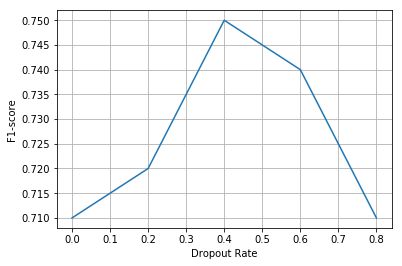

In [37]:
#Hyperparameter tuning
'''
We see that given the higher train accuracy and relatively lower test accuracy that the model is overfitting
the data. Therefore we introduce Dropout and experiment with the Dropout rate to get an idea of how the model
performs. We plot a graph of the F1-score of positive examples vs Dropout score
'''



In [52]:
#Hyperparameter tuning
'''
From the graph of Dropout we observe that a value of ~0.5 is a good value for the Dropout rate.

Another hyperparameter which we can experiment with is the sgd optimizer. We experiment with different
optimizers like rmsprop, adam, adadelta, adagrad and nag by plotting the loss vs the number of epochs
and compare them.
'''
adam=loss
print (adam)





[0.22134680912344162, 0.1210429784764483, 0.06400577929427853, 0.03570195148231777, 0.021537292965276296, 0.0139366957263099, 0.011073357738133682, 0.01494792425785325, 0.010399755528676276, 0.006911406922386186]


In [56]:
rmsprop=loss
print(rmsprop)

[0.22897164075576587, 0.2055489333761095, 0.0860031706890543, 0.0470270368075648, 0.03189219031451994, 0.018120765832231142, 0.009695336783066565, 0.007388953394117298, 0.0065601830629081126, 0.005271682758626847]


In [60]:
adadelta=loss
print (adadelta)

[0.21960905874364597, 0.12775591078935272, 0.07387387119171726, 0.04498517225214908, 0.02683140088083142, 0.016043398585758387, 0.009027463817145935, 0.04446468594800765, 0.01558469291730672, 0.010869572544006315]


In [64]:
adagrad=loss
print (adagrad)

[0.3508525948191798, 0.3223314627361456, 0.3031971598186366, 0.287048080632853, 0.2759555968582828, 0.26333734410446746, 0.2523258566064296, 0.2450596965181075, 0.23528286834491843, 0.22836931802307647]


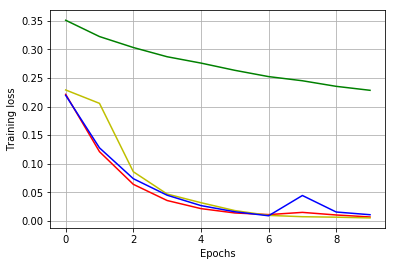

In [68]:
import matplotlib.pyplot as plt

plt.plot(adam,'r',label='adam') #in red
plt.plot(rmsprop,'y',label='rmsprop') #in yellow
plt.plot(adadelta,'b',label='adadelta') #in blue
plt.plot(adagrad,'g',label='adagrad') #in green

plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

In [ ]:
'''
Given the consistently lower training loss of adam and rmsprop, these would be a good optimizers for our task
'''